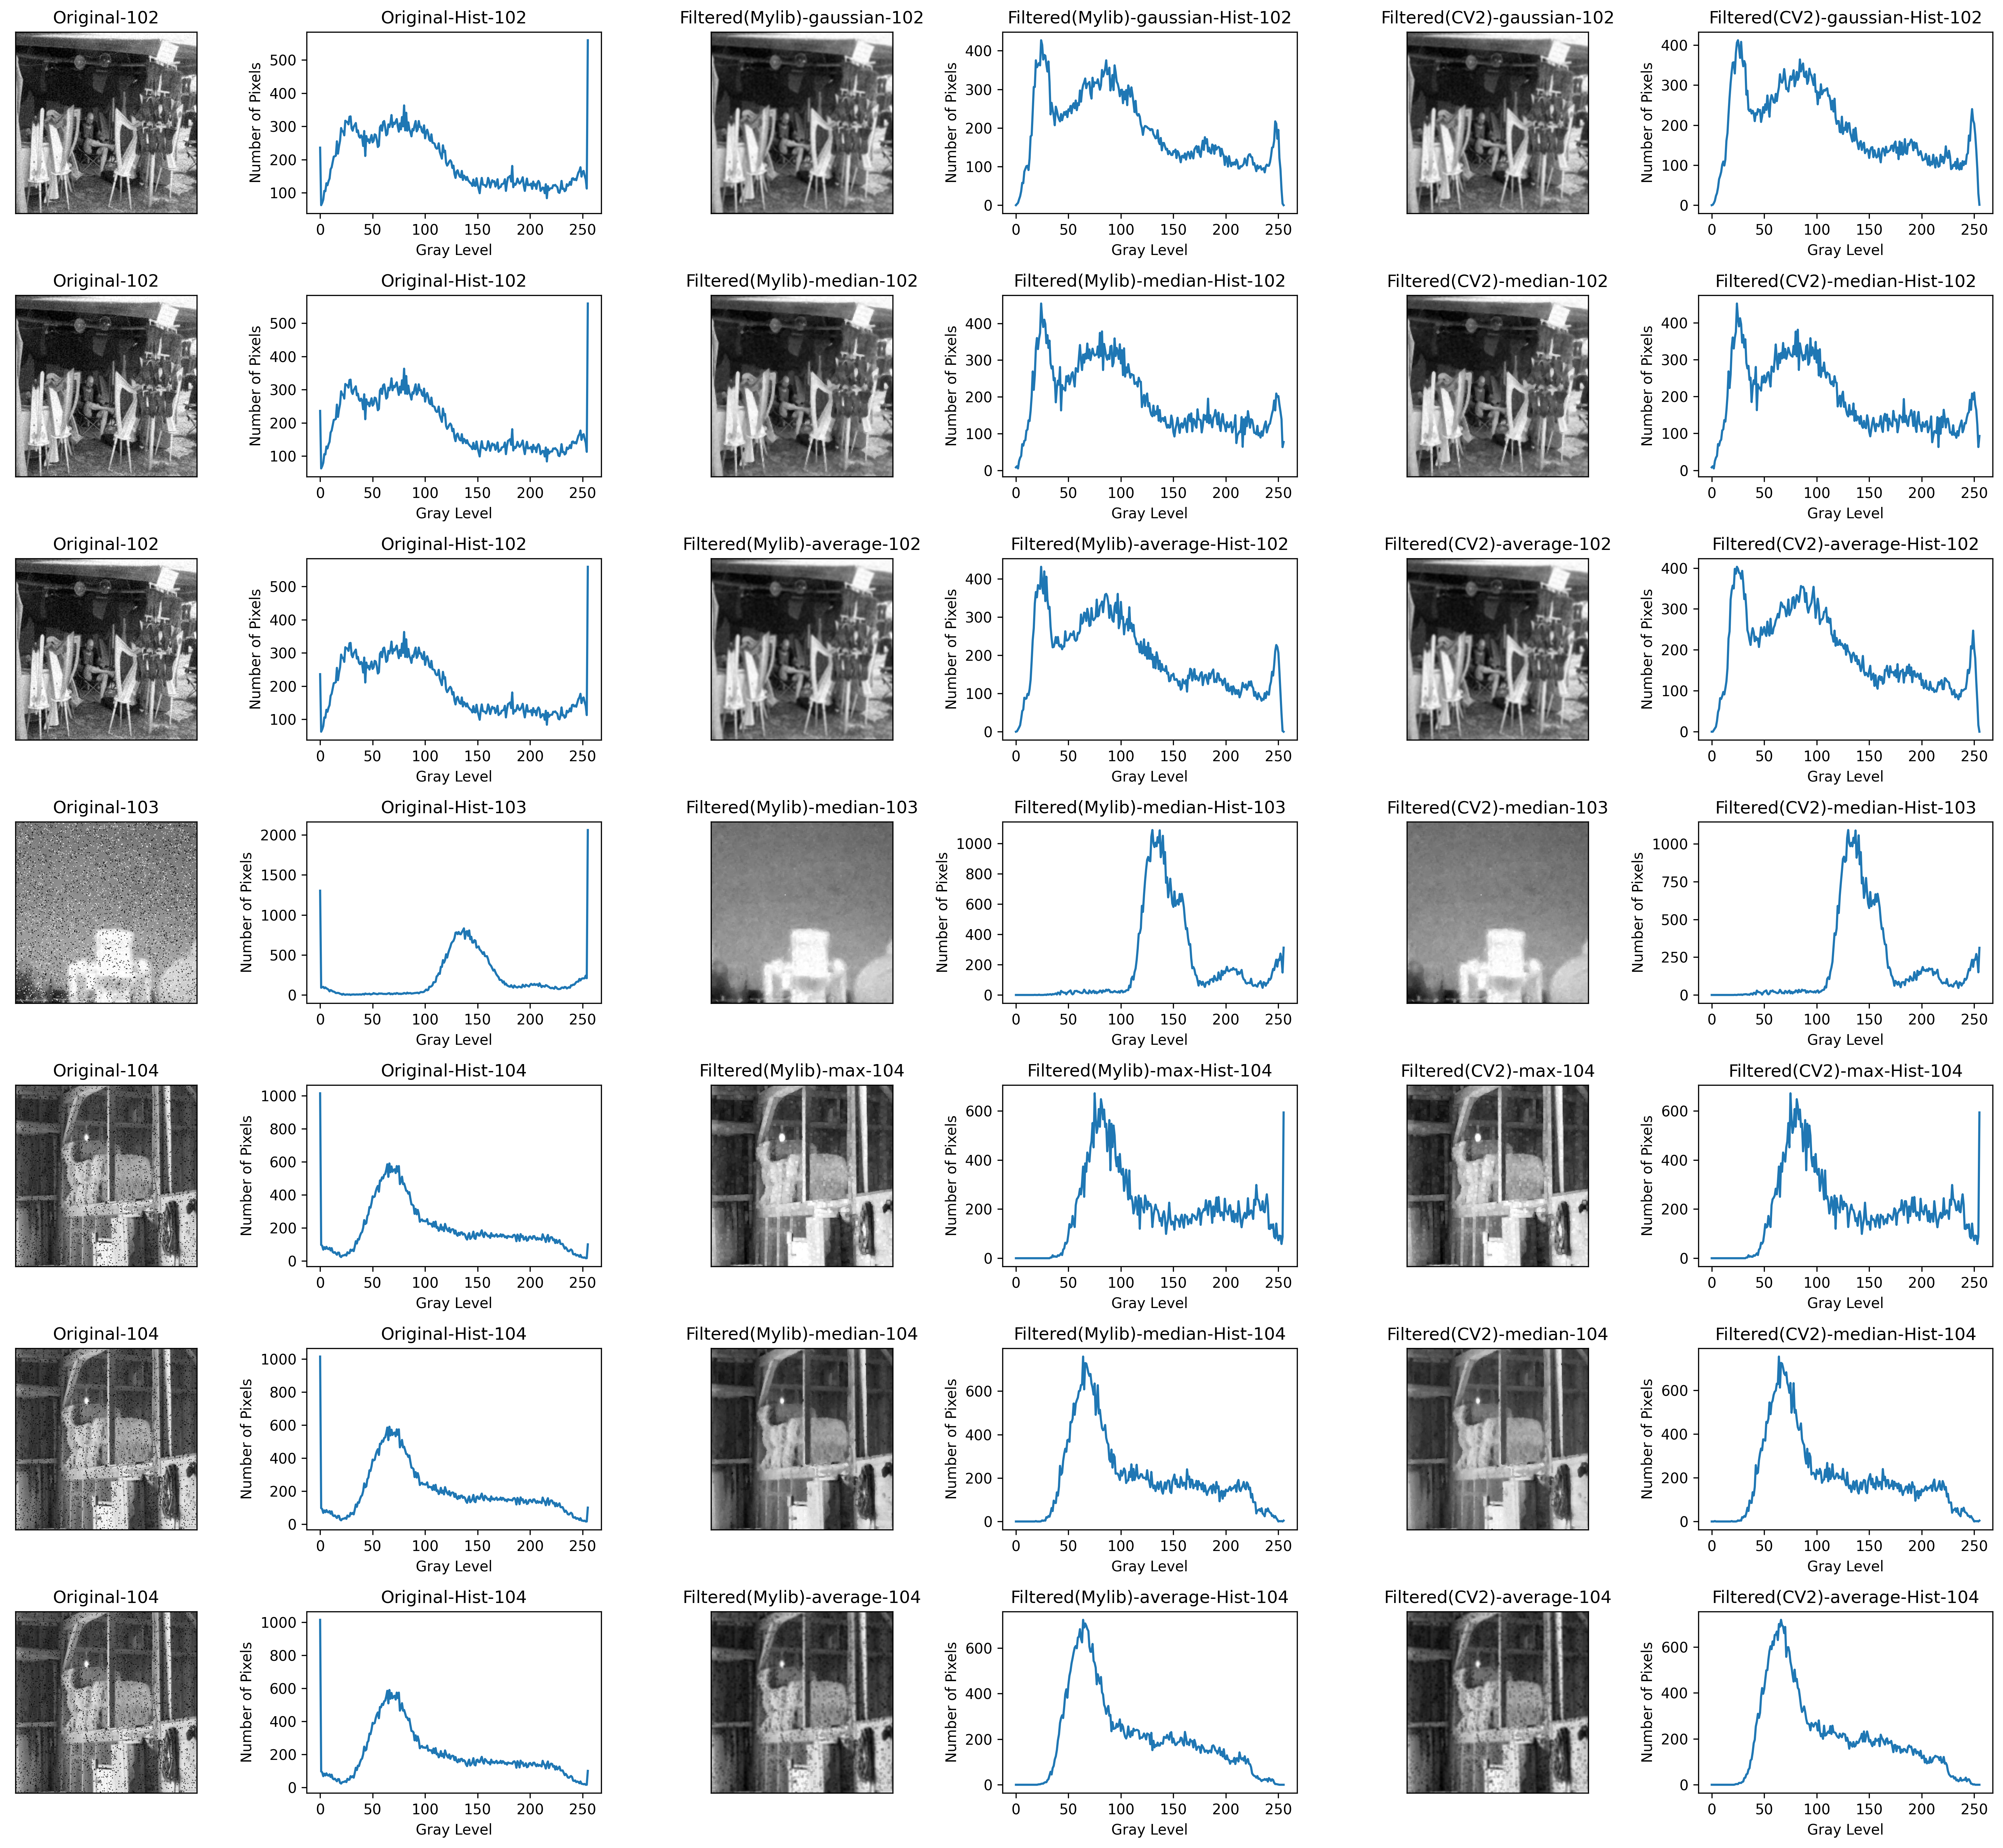

In [69]:
#!/usr/bin/env python3

import cv2
import numpy as np
import matplotlib.pyplot as plt
import math

class NoiseDetector(object):
    def __init__(self) -> None:
        pass
    
    def hist(self, img: cv2.Mat, bins: int, range: tuple):
        hist = cv2.calcHist([img], [0], None, [bins], range)
        return hist
    
    def sample(self, img: cv2.Mat, sample_size: int):
        height, width = img.shape
        x = np.random.randint(0, width, sample_size)
        y = np.random.randint(0, height, sample_size)
        return img[y, x]

class FrequencyFilter(object):
    def __init__(self, filter_type):
        self.filter_type = filter_type
    
    def __convert_to_frequency_domain(self, image: cv2.Mat):
        f = np.fft.fft2(image)
        fshift = np.fft.fftshift(f)
        return fshift

    def __convert_to_spatial_domain(self, fshift: cv2.Mat):
        f_ishift = np.fft.ifftshift(fshift)
        img_back = np.fft.ifft2(f_ishift)
        img_back = np.abs(img_back)
        return img_back


class SpatialFilter(object):
    def __init__(self, filter_type):
        self.filter_type = filter_type
        self.filter_lib = "cv2"
    
    def util_move_kernel(self, image: cv2.Mat, kernel_size, new_image: cv2.Mat, filter_hook):       
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                # i, j is the center of the kernel
                left_bound = max(0, i - kernel_size // 2)
                right_bound = min(image.shape[0], i + kernel_size // 2 + 1)
                top_bound = max(0, j - kernel_size // 2)
                bottom_bound = min(image.shape[1], j + kernel_size // 2 + 1)
                filter_hook(new_image, i, j, image[left_bound: right_bound, top_bound: bottom_bound])
            
    def __gaussian(self, image, kernel_size, sigma=1):
        if self.filter_lib == "cv2":
            return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
        elif self.filter_lib == "mylib":
            # ref: https://blog.csdn.net/a435262767/article/details/107115249
            new_image = image.copy()
            # prepare the kernel
            kernel = np.zeros((kernel_size, kernel_size))
            for i in range(kernel_size):
                for j in range(kernel_size):
                    kernel[i, j] = (1 / (2 * math.pi * sigma * sigma)) * np.exp(-((i - kernel_size // 2) ** 2 + (j - kernel_size // 2) ** 2) / 2 * sigma * sigma)
            # normalize the kernel
            kernel = kernel / np.sum(kernel)
            def gaussian_hook(new_image: cv2.Mat, i, j, partial_image: cv2.Mat):
                # pad the partial image to (kernel_size, kernel_size)
                padded_partial_image = np.zeros((kernel_size, kernel_size))
                padded_partial_image[:partial_image.shape[0], :partial_image.shape[1]] = partial_image
                # convolution with kernel
                new_image[i, j] = np.sum(padded_partial_image * kernel)
            self.util_move_kernel(image, kernel_size, new_image, gaussian_hook)
            return new_image
        
    def __average(self, image: cv2.Mat, kernel_size):
        if self.filter_lib == "cv2":
            return cv2.blur(image, (kernel_size, kernel_size))
        elif self.filter_lib == "mylib":
            new_image = image.copy()
            def average_hook(new_image: cv2.Mat, i, j, partial_image: cv2.Mat):
                new_image[i, j] = np.mean(partial_image)
            self.util_move_kernel(image, kernel_size, new_image, average_hook)
            return new_image
    
    def __median(self, image: cv2.Mat, kernel_size):
        if self.filter_lib == "cv2":
            return cv2.medianBlur(image, kernel_size)
        elif self.filter_lib == "mylib":
            new_image = image.copy()
            def median_hook(new_image: cv2.Mat, i, j, partial_image: cv2.Mat):
                new_image[i, j] = np.median(partial_image)
            self.util_move_kernel(image, kernel_size, new_image, median_hook)
            return new_image
            
    def __min(self, image: cv2.Mat, kernel_size):
        if self.filter_lib == "cv2":
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            return cv2.erode(image, kernel, iterations=1)
        elif self.filter_lib == "mylib":
            new_image = image.copy()
            def min_hook(new_image: cv2.Mat, i, j, partial_image: cv2.Mat):
                new_image[i, j] = np.min(partial_image)
            self.util_move_kernel(image, kernel_size, new_image, min_hook)
            return new_image
            
    def __max(self, image: cv2.Mat, kernel_size):
        if self.filter_lib == "cv2":
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            return cv2.dilate(image, kernel, iterations=1)
        elif self.filter_lib == "mylib":
            new_image = image.copy()
            def max_hook(new_image: cv2.Mat, i, j, partial_image: cv2.Mat):
                new_image[i, j] = np.max(partial_image)
            self.util_move_kernel(image, kernel_size, new_image, max_hook)
            return new_image
        
    def apply_filter(self, image_path, kernal_size, method="cv2"):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        
        original_method = self.filter_lib
        self.filter_lib = method 

        if self.filter_type == "gaussian":
            res = self.__gaussian(img, kernal_size)
        elif self.filter_type == "average":
            res = self.__average(img, kernal_size)
        elif self.filter_type == "median":
            res = self.__median(img, kernal_size)
        elif self.filter_type == "min":
            res = self.__min(img, kernal_size)
        elif self.filter_type == "max":
            res =  self.__max(img, kernal_size)
        else:
            res = img
        
        self.filter_lib = original_method
        return res

if __name__ == '__main__' and '__file__' not in globals():
    noise_detector = NoiseDetector()
    image_paths = ["./Q1_image/102.jpeg", "./Q1_image/102.jpeg", "./Q1_image/102.jpeg", 
                   "./Q1_image/103.jpeg", 
                   "./Q1_image/104.jpeg", "./Q1_image/104.jpeg", "./Q1_image/104.jpeg"]
    image_titles = ["102", "102", "102", 
                    "103", 
                    "104", "104", "104"]
    filters = [SpatialFilter("gaussian"),  SpatialFilter("median"), SpatialFilter("average"), SpatialFilter("median"), SpatialFilter("max"), SpatialFilter("median"), SpatialFilter("average")]
    COL_IMAGES = 6

    plt.figure(figsize=(20, 18), dpi = 300)

    for filter, image_path in zip(filters, image_paths):
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        my_res = filter.apply_filter(image_path, 3, "mylib")
        res = filter.apply_filter(image_path, 3, "cv2")
        
        for process_id, process in enumerate([(img, "Original"), (my_res, "Filtered(Mylib)-" + filter.filter_type), (res, "Filtered(CV2)-" + filter.filter_type)]):
            img = process[0]
            img_prefix = process[1]
            
            plt.subplot(len(filters), COL_IMAGES, COL_IMAGES * filters.index(filter) + process_id * 2 + 1)
            plt.imshow(img, cmap="gray")
            plt.title(img_prefix + "-" + image_titles[filters.index(filter)])
            plt.xticks([])
            plt.yticks([])

            if img_prefix != "Original":
                # save image
                cv2.imwrite("./SpatialFiltered/output_" + img_prefix + "-" + image_titles[filters.index(filter)] + ".jpeg", img)

            plt.subplot(len(filters), COL_IMAGES, COL_IMAGES * filters.index(filter) + process_id * 2 + 2) 
            hist = noise_detector.hist(img, 256, [0, 256])
            plt.plot(hist, label=image_path)
            plt.xlabel("Gray Level")
            plt.ylabel("Number of Pixels")
            plt.title(img_prefix + "-Hist-" + image_titles[filters.index(filter)])
        
    plt.tight_layout()
    plt.savefig("./SpatialFiltered/result.jpeg", pad_inches=0)
    plt.show()
